### **Çok Değişkenli Aykırı Değer Analizi (Local Outlier Factor)** 

LOF NEDİR?

Gözlemleri bulundukları konumda yoğunluk tabanlı skorlayarak buna göre aykırı değer olabilecek tanımlayabilmemize imkan sağlıyor.

Bir noktanın kocal yoğunluğu bu noktanın komşuları ile karşılaştırılıyor. Eğer bir nokta  komşularının yoğunluğundan anlamlı bir şekilde düşük ise bu nokta komşularından daha seyrek bir bölgede bulunuyordur yorumu yapılıyor. Dolayısıyla burada bir komşuluk yapısı söz konusu. Bir değerin çevresi yoğun değilse demek ki bu değer aykırı değerdir şeklinde değerlendiriliyor. 




In [1]:
##################### GEÇMİŞ TANIMLAMALAR ##############################

# Kütüphaneler

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


# Pandas ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


# Veri setleri
def load_application_train():
    data = pd.read_csv('application_train.csv')
    return data

def load():
    data = pd.read_csv('titanic.csv')
    return data


# Tanımlama
df_train = load_application_train()
df = load()


# Fonksiyonlar
# outlier_thresholds fonksiyonu
# Alt ve üst sınırlarının belirlemek için kullanılacak
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Aykırı değer var mı yok mu kontrol eden fonksiyonu tanımlayalım. (return: True/False)(bool)
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

    # Bunu da kullanabiliriz.
    # if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].empty:
    #     return False
    # else:
    #     return True
        
# Efsane fonksiyon

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    -------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe.
        cat_th: int, optinal
                Kategorik değişkenlerinin sayısının üst sınırı.
        car_th: int, optional
                Kategorik fakat kardinal değişkenler için sınıf eşik değeri.
    
    Returns
    -------
        cat_cols: list
                Kategorik değişken listesi.
        num_cols: list
                Numerik değişken listesi.
        cat_but_car: list
                Kategorik kardinal değişken listesi.
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtype != 'O']
                   
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                     dataframe[col].dtype == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print("******************")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

# grab_outliers fonksiyonu (eğer değişkene ait aykırı değer sayısı 10 dan fazla ise ilk 5 değerini göster, az ise hepsini göster)
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 0:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
        

# Aykırı olmayan gözlemleri dönen fonksiyonları yazalım.
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_wıthout_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_wıthout_outliers




> Tek değişken için bakıldığında aykırı olmayan gözlemler, birden çok değişken için bakıldığında aykırı olabilir.

Örneğin: 17 yaşında birinin 3 kere evlenmesi aykırı değerdir ama 17 yaşında olmak ve 3 kere evlenmek ayrı ayrı bakıldığında aykırı değer değildir.

In [3]:
# Veri setini tanımlayalım.
df = sns.load_dataset('diamonds')

In [4]:
# Sayısal değişkenleri seçelim.
df = df.select_dtypes(include=['float64', 'int64'])

In [6]:
df = df.dropna()
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [7]:
# Veri setindeki gözlemlere bakalım.
df.shape

(53940, 7)

In [8]:
# Değişkenlerde aykırı gözlem var mı?
for col in df.columns:
    print(col , check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [9]:
low, up = outlier_thresholds(df, 'carat')

In [11]:
# Karat değişkeni için aykırı gözlemlere bakalım.
df[((df['carat'] < low) | (df['carat'] > up))].shape

(1889, 7)

In [12]:
low, up = outlier_thresholds(df, 'depth')

In [13]:
# Derinlik değişkeni için aykırı gözlemlere bakalım.
df[((df['depth'] < low) | (df['depth'] > up))].shape

(2545, 7)

In [14]:
clf = LocalOutlierFactor(n_neighbors=20) # n_neighbors aranan komşuluk sayısıdır.

In [15]:
# LOF u veri setine uygulamak için
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [22]:
# Lof değerlerini takip edebilmek için
df_scores = clf.negative_outlier_factor_

In [23]:
# Skorlara bakalım.
df_scores

array([-1.58352526, -1.59732899, -1.62278873, ..., -1.06721815,
       -1.00809552, -1.00849038])

In [21]:
# Eksi değerli gözkükmesini istemiyorsak
# df_scores = -df_scores

In [24]:
np.sort(df_scores)[0:5]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

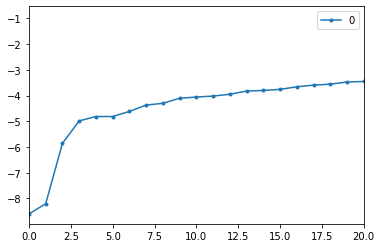

In [25]:
# Skor grafiği
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True,xlim=[0,20],style=".-")
plt.show()

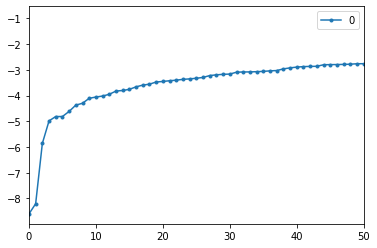

In [27]:
# Daha detaylı bakalım.
scores.plot(stacked=True,xlim=[0,50],style=".-")
plt.show()

In [28]:
# Grafiğe bakarak kırılma noktasını belirleyelim.
th = np.sort(df_scores)[3]

In [29]:
#  LOF'a göre aykırı değerlere bakalım
df[df_scores < th]

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


In [30]:
# Bunlar neden aykırı?
df.describe([0.01,0.05,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800
